# Example: Compare distributions for common particles in two models

In this example, we generate the pseudorapidity and Feynman-x distributions for selected particles in two models and compare them visually.

Requires extra packages: matplotlib, tqdm, boost-histogram, particle

In [1]:
import matplotlib.pyplot as plt
import boost_histogram as bh
from tqdm import tqdm
from particle import literals as lp, Particle

from impy.constants import TeV
from impy.kinematics import EventKinematics
from impy import models
from impy import impy_config

In [2]:
# Global options can be set via impy_config
impy_config["user_frame"] = 'center-of-mass'
impy_config['tau_stable'] = 10e-12
impy_config['pi0_stable'] = True
# impy_config['debug_level'] = 5

In [3]:
# We want to simulate pp interactions at 1 TeV center-of-mass

# The event kinematics objects defines the collision and its frame.
# Here we want pp collisions at 1 TeV center-of-mass energy.
event_kinematics = EventKinematics(
    ecm= 1 * TeV,
    p1pdg=lp.proton.pdgid,
    p2pdg=lp.proton.pdgid
)

# How many events to generate
n_events = 10000

In [4]:
# Create instances of two different models.
# This typically generates a banner for each model.

m1 = models.Sibyll21(event_kinematics)

m2 = models.Sibyll23d(event_kinematics)

 |                                                  |
 |                 S I B Y L L  2.1                 |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                   Ralph ENGEL                    |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 | Publication to be cited when using this program: |
 | R. Engel et al., Proc. 26th ICRC, 1 (1999) 415   |
 |                                                  |
 | last modified:  28. Sept. 2001 by R. Engel       |


 Table: J, sqs,  PT_cut,  SIG_tot,  SIG_inel,  B_el,  rho,  <n_s>,  <n_h>
 ------------------------------------------------------------------------
    1   1.000E+01    1.45   38.33   30.88   10.83  -0.185   1.964   0.003
    1   1.259E+01    1.49   38.27   31.16   11.10  -0.127   1.949   0.006


In [5]:
results = {}

pid_axis = bh.axis.IntCategory([
    x.pdgid for x in (lp.pi_0, lp.pi_plus, lp.pi_minus, lp.K_plus, lp.K_minus, lp.proton, lp.antiproton)
])

for m in (m1, m2):
    # Histogram for Feynman-x distributions
    hx = bh.Histogram(pid_axis, bh.axis.Regular(30, -1, 1))

    # Histogram for pseudorapidity distributions
    heta = bh.Histogram(pid_axis, bh.axis.Regular(30, -7, 7))

    for event in tqdm(m(n_events), total=n_events):
        event.filter_final_state() # select only final state particles
        hx.fill(event.p_ids, event.xf)
        heta.fill(event.p_ids, event.eta)
    
    results[m.label] = hx, heta


100%|██████████| 10000/10000 [00:02<00:00, 4451.25it/s]


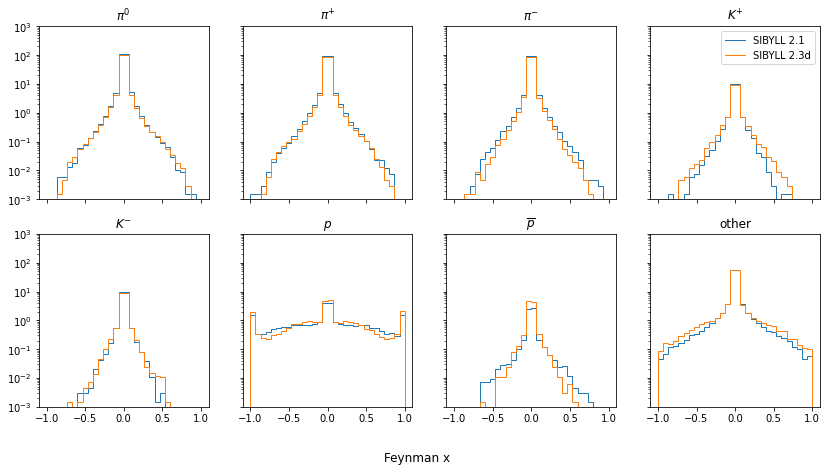

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

# boost-histogram axes contain overflow bins to count everything else,
# we use this here to show a histogram of all other particles
labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in pid_axis]
labels += ["other"]

for model, (hx, heta) in results.items():
    a = hx.axes[1]
    values = hx.values(True) # this returns the full histogram including overflow bins
    values = values[:, 1:-1] # strip the overflow bins from the second axis
    labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in hx.axes[0]]
    labels += ["other"]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e3)
fig.supxlabel("Feynman x")
ax[0, -1].legend();

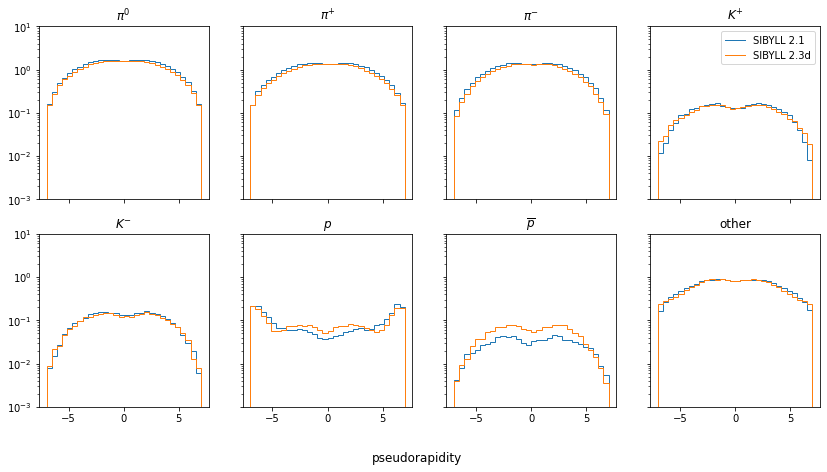

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

for model, (hx, heta) in results.items():
    a = heta.axes[1]
    values = heta.values(True)
    values = values[:, 1:-1]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e1)
fig.supxlabel("pseudorapidity")
ax[0, -1].legend();

In [8]:
# Looking at event lists for model 1

for event in m1(3):
    event.filter_final_state_charged()
    print('Event {5:4}   {0:8} {1:10} {2:10} {3:10} {4:10}'.format('pid', 'px', 'py', 'pz', 'e', event.nevent))
    for ip, (pid, x, y, z, e) in enumerate(zip(event.p_ids, event.px, event.py, event.pz, event.en)):
        print('   {5:4}: {0:8} {1:10.2e} {2:10.2e} {3:10.2e} {4:10.2e}'.format(pid, x, y, z, e, ip))

Event    0   pid      px         py         pz         e         
      0:     2212   9.23e-02   2.18e-01  -5.00e+02   5.00e+02
      1:      211   2.32e-01  -2.83e-01   2.63e+02   2.63e+02
      2:      321   8.83e-02   2.19e-01   5.72e+01   5.72e+01
      3:     -211  -3.28e-01   8.98e-02   2.23e+01   2.23e+01
Event    0   pid      px         py         pz         e         
      0:      211   3.70e-01  -1.52e-01   9.75e-01   1.06e+00
      1:     -211   7.84e-02  -2.29e-02   5.55e-01   5.78e-01
      2:      211  -2.42e-01   3.10e-01   4.55e+00   4.57e+00
      3:     -211   4.50e-01  -1.75e-01   4.00e+01   4.00e+01
      4:      211   1.55e-01   4.11e-01   2.60e+02   2.60e+02
      5:     2212   6.91e-01  -2.13e-02  -2.50e+02   2.50e+02
      6:      321  -9.92e-01   5.89e-01  -7.83e+01   7.83e+01
      7:      211   1.64e-01  -8.46e-02   2.08e+00   2.09e+00
      8:     -211  -2.45e-01   1.22e-01   1.70e+01   1.71e+01
      9:      211  -3.82e-02   1.09e-01   1.62e+00   1.63e+00
